In [1]:
import control.matlab as matlab
import numpy as np
import matplotlib.pyplot as plt

In [4]:
#マルチコプタサンプルの数値例計算　Ver 0.0 (2021.7.4 (c)Kouhei)
import numpy as np

###重力加速度
grav=9.80665

###モータのパラメータ
Jm=3.4e-6
Lm=3.7e-6
Rm=0.12
Km=3.28e-3
Dm=0.0
Qf=0.0

###プロペラのパラメータ
Ct=8.3e-7
Cq=3.0e-8

###各パーツの質量(kg)
mm=0.045 #モータ+プロペラ 0.045
mf=0.19 #フレーム
ml=0.02 #脚
mb=0.26 #電池

###各パーツの大きさ(m)
##モータ
Dim=0.038 #直径
rm=Dim/2 #半径
hm=0.016 #高さ

##フレーム
ef=0.292 #長辺の長さ
af=0.127 #１本のアームの根本からの長さ
aw=ef-2*af #アームの幅
df=(ef-af)/np.sqrt(2) #フレームの中心とフレームの空き空間の中心距離

##脚
Dl=0.03 #脚の直径
rl=Dl/2 #脚の半径
hl=0.036 #脚の高さ

##電池
hb=0.016 #電池高さ
wb=0.05 #電池幅
lb=0.15 #電池長さ

###各パーツの位置関係
##x軸
mlx=0.0 #モータ＋プロペラと脚の距離（x軸）
fbx=0.0 #フレームと電池の距離（x軸）
flx=0.18/2 #フレームと脚の距離（x軸）
llx=0.18 #脚の間隔
mmx=0.18 #モータの間隔
mfx=0.18/2
##y軸
mly=0.0 #モータ＋プロペラと脚の距離（y軸）
fby=0.0 #フレームと電池の距離（y軸）
fly=0.18/2 #フレームと脚の距離（y軸）
lly=0.18 #脚の間隔
mmy=0.18 #モータの間隔
mfy=0.18/2
##z軸
mlz=0.046 #モータ＋プロペラと脚の距離（z軸）
fbz=0.018 #フレームと電池の距離（z軸）
flz=0.028 #フレームと脚の距離（z軸）

###各パーツの機体重心を原点とした座標
##x軸
mlFR=2*ml
mlRR=2*ml
mmFR=2*mm
mmRR=2*mm
Ax=np.matrix([[2*mlFR, 2*mlRR, mb, mf, 2*mmFR, 2*mmRR],\
              [1,-1, 0, 0, 0, 0],\
              [0, 0, 0, 0, 1,-1],\
              [0, 0, 1,-1, 0, 0],\
              [1, 0, 0,-1, 0, 0],\
              [0, 0, 0,-1, 1, 0]])
Bx=np.matrix([[0],[llx],[mmx],[fbx],[mfx],[flx]])
Xa=np.linalg.inv(Ax)*Bx
lFRx=lFLx=Xa[0,0]
lRRx=lRlx=Xa[1,0]
bx=Xa[2,0]
fx=Xa[3,0]
mFRx=mFLx=Xa[4,0]
mRRx=mRLx=Xa[5,0]

##y軸
mlRR=2*ml
mlRL=2*ml
mmRR=2*mm
mmRL=2*mm
Ay=np.matrix([[2*mlRR, 2*mlRL, mb, mf, 2*mmRR, 2*mmRL],\
              [1,-1, 0, 0, 0, 0],\
              [0, 0, 0, 0, 1,-1],\
              [0, 0, 1,-1, 0, 0],\
              [1, 0, 0,-1, 0, 0],\
              [0, 0, 0,-1, 1, 0]])
By=np.matrix([[0],[lly],[mmy],[fby],[mfy],[fly]])
Ya=np.linalg.inv(Ay)*By
lFRy=lRRy=Ya[0,0]
lFLy=lRLy=Ya[1,0]
by=Ya[2,0]
fy=Ya[3,0]
mFRy=mRRy=Ya[4,0]
mFLy=mRLy=Ya[5,0]

##z軸
Az=np.matrix([[4*ml, mb, mf, 4*mm],\
              [-1, 0, 0, 1],\
              [ 0,-1, 1, 0],\
              [-1, 0, 1, 0]])
Bz=np.matrix([[0],[mlz],[fbz],[flz]])
Za=np.linalg.inv(Az)*Bz
lz=Za[0,0]
bz=Za[1,0]
fz=Za[2,0]
mz=Za[3,0]


###各パーツの慣性モーメント
##モータ
Imx=Imy=0.25*mm*rm**2+mm*hm**2/12
Imz=0.5*mm*rm**2

##フレーム
#計算準備
sf=4*(af*aw)+aw**2 #フレームの上面から見た面積
se=af**2 #空白部分の面積
sl=aw*ef #長い長方形の面積
sa=aw*af #アームの面積
mfs=mf*ef**2/sf #空白部分が満たされていたときの質量
mfe=mf*se/sf #空白部分の質量
mfl=mf*sl/sf #長い長方形の質量
ma=mf*sa/sf #アームの質量
#ここから慣性モーメント
Icg= mfe*af**2/6 + mfe*df**2 #空き空間に正方形の物体が有ったとしたときの慣性モーメント
Ifx=Ify=mfl*(ef**2+aw**2)/12+2*ma*(af**2+aw**2)/12
Ifz=mfs*ef**2/6-4*Icg

##脚
Ilx=Ily=0.5*ml*rl**2
Ilz= 0.25*ml*rl**2+ ml*hl**2/12

##電池
Ibx=mb*(wb**2+hb**2)/12
Iby=mb*(lb**2+hb**2)/12
Ibz=mb*(wb**2+lb**2)/12

###各パーツの重心からの距離
##xz&yz平面
dlxz=dlyz=np.sqrt(lFRx**2 + lz**2)
dbxz=dbyz=np.sqrt(  bx**2 + bz**2)
dfxz=dfyz=np.sqrt(  fx**2 + fz**2)
dmxz=dmyz=np.sqrt(mFRx**2 + mz**2)
#print('dlxz={:10.2e} \ndbxz={:10.2e} \ndfxz={:10.2e} \ndmxz={:10.2e}\n'.format(dlxz,dbxz,dfxz,dmxz))

##xy平面
dlxy=np.sqrt(lFRx**2 + lFRy**2)
dbxy=np.sqrt(  bx**2 + by**2)
dfxy=np.sqrt(  fx**2 + fy**2)
dmxy=np.sqrt(mFRx**2 + mFRy**2)
#print('dlxy={:10.2e} \ndbxy={:10.2e} \ndfxy={:10.2e} \ndmxy={:10.2e}\n'.format(dlxy,dbxy,dfxy,dmxy))


###マルチコプタの慣性モーメント
##x軸周り　yz平面
Ix=(4*(Imx + mm*dmyz**2)+\
       Ifx + mf*dfyz**2 +\
       Ibx + mb*dbyz**2 +\
       4*(Ilx + ml*dlyz**2))
##y軸周り　xz平面
Iy=(4*(Imy + mm*dmxz**2)+\
       Ify + mf*dfxz**2 +\
       Iby + mb*dbxz**2 +\
       4*(Ily + ml*dlxz**2))
##z軸周り　xy平面
Iz=(4*(Imz + mm*dmxy**2)+\
    Ifz + mf*dfxy**2 +\
    Ibz + mb*dbxy**2 +\
    4*(Ilz + ml*dlxy**2))

###マルチコプタ質量
Mass=mm*4+mf+ml*4+mb

### 伝達関数パラメータ
omega0=0.5*np.sqrt(Mass*grav/Ct)
e0=Rm*((Dm + Km**2/Rm)*omega0 + Cq*omega0**2 + Qf)/Km
taum=Jm*Rm/(Dm*Rm+Km**2+2*Rm*Cq*omega0)
Kw=2*Ct*omega0*Km/(Dm*Rm+Km**2+2*Rm*Cq*omega0)/Mass
Kroll=mmx*Ct*omega0*Km/(Dm*Rm+Km**2+2*Rm*Cq*omega0)/Ix
Kpitch=mmx*Ct*omega0*Km/(Dm*Rm+Km**2+2*Rm*Cq*omega0)/Iy
Kyaw=2*Cq*omega0*Km/(Dm*Rm+Km**2+2*Rm*Cq*omega0)/Iz


###結果表示
print('### Mass ###')
print('{:10.2e}'.format(Mass))

print('\n### Equilibrium value ###')
print('omega0={:10.2e}'.format(omega0))
print('e0={:10.2e}'.format(e0))

print('\n### Transfer Function Parameter ###')
print('tau={:10.2e}'.format(taum))
print('Kw={:10.2e}'.format(Kw))
print('Kroll(Kp)={:10.2e}'.format(Kroll))
print('Kpitch(Kq)={:10.2e}'.format(Kpitch))
print('Kyaw(Kr)={:10.2e}'.format(Kyaw))

print('\n### Inertia　tensor  ###\n')
print('Motor+Prop')
print('Imx={:10.2e}'.format(Imx))
print('Imy={:10.2e}'.format(Imy))
print('Imz={:10.2e}'.format(Imz))
print('\nFrame')
print('Ifx={:10.2e}'.format(Ifx))
print('Ify={:10.2e}'.format(Ify))
print('Ifz={:10.2e}'.format(Ifz))
print('\nLeg')
print('Ilx={:10.2e}'.format(Ilx))
print('Ily={:10.2e}'.format(Ily))
print('Ilz={:10.2e}'.format(Ilz))
print('\nBattery')
print('Ibx={:10.2e}'.format(Ibx))
print('Iby={:10.2e}'.format(Iby))
print('Ibz={:10.2e}'.format(Ibz))

print('\n## Multi Copter ##')
print('Ix={:10.2e}'.format(Ix))
print('Iy={:10.2e}'.format(Iy))
print('Iz={:10.2e}'.format(Iz))

print('\n### Position from Center of Gravity ###')
print('\nMotor Position')
print('Front Right Motor:({:10.2e},{:10.2e},{:10.2e})'.format(mFRx,mFRy,mz))
print('Front Left  Motor:({:10.2e},{:10.2e},{:10.2e})'.format(mFLx,mFLy,mz))
print('Rear  Right Motor:({:10.2e},{:10.2e},{:10.2e})'.format(mRRx,mRRy,mz))
print('Rear  Left  Motor:({:10.2e},{:10.2e},{:10.2e})'.format(mRLx,mRLy,mz))

print('\nFrame Position')
print('({:10.2e},{:10.2e},{:10.2e})'.format(fx,fy,fz))

print('\nBattery Position')
print('({:10.2e},{:10.2e},{:10.2e})'.format(bx,by,bz))

print('\nLeg Position')
print('Front Right Leg:({:10.2e},{:10.2e},{:10.2e})'.format(lFRx,lFRy,lz))
print('Front Left  Leg:({:10.2e},{:10.2e},{:10.2e})'.format(lFLx,lFLy,lz))
print('Rear  Right Leg:({:10.2e},{:10.2e},{:10.2e})'.format(lRRx,lRRy,lz))
print('Rear  Left  Leg:({:10.2e},{:10.2e},{:10.2e})'.format(lRlx,lRLy,lz))


### Mass ###
  7.10e-01

### Equilibrium value ###
omega0=  1.45e+03
e0=  7.05e+00

### Transfer Function Parameter ###
tau=  1.93e-02
Kw=  5.24e-01
Kroll(Kp)=  1.03e+01
Kpitch(Kq)=  9.11e+00
Kyaw(Kr)=  2.15e+00

### Inertia　tensor  ###

Motor+Prop
Imx=  5.02e-06
Imy=  5.02e-06
Imz=  8.12e-06

Frame
Ifx=  8.64e-04
Ify=  8.64e-04
Ifz=  1.47e-03

Leg
Ilx=  2.25e-06
Ily=  2.25e-06
Ilz=  3.28e-06

Battery
Ibx=  5.97e-05
Iby=  4.93e-04
Ibz=  5.42e-04

## Multi Copter ##
Ix=  3.24e-03
Iy=  3.68e-03
Iz=  6.26e-03

### Position from Center of Gravity ###

Motor Position
Front Right Motor:(  9.00e-02,  9.00e-02,  2.32e-02)
Front Left  Motor:(  9.00e-02, -9.00e-02,  2.32e-02)
Rear  Right Motor:( -9.00e-02,  9.00e-02,  2.32e-02)
Rear  Left  Motor:( -9.00e-02, -9.00e-02,  2.32e-02)

Frame Position
(  0.00e+00,  0.00e+00,  5.18e-03)

Battery Position
(  0.00e+00,  0.00e+00, -1.28e-02)

Leg Position
Front Right Leg:(  9.00e-02,  9.00e-02, -2.28e-02)
Front Left  Leg:(  9.00e-02, -9.00e-02, -2.28e-02)

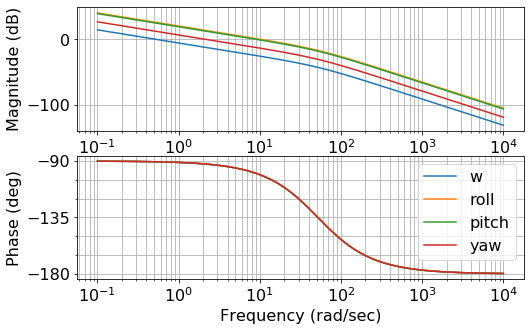

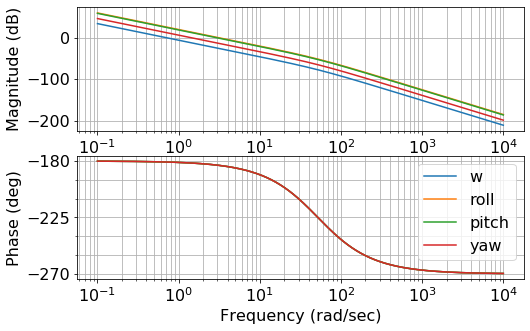

In [5]:
##レート系伝達関数
sysw=matlab.tf(Kw,[taum, 1, 0])
sysp=matlab.tf(Kroll,[taum, 1, 0])
sysq=matlab.tf(Kpitch,[taum, 1, 0])
sysr=matlab.tf(Kyaw,[taum, 1, 0])

#ボード線図描画
plt.figure(figsize=(8,5))
plt.rcParams["font.size"] = 16
wfreq=np.logspace(-1,4,1000)
magw,phadew,omegaw = matlab.bode(sysw,wfreq,label='w')
magp,phadep,omegap = matlab.bode(sysp,wfreq,label='roll')
magq,phadeq,omegaq = matlab.bode(sysq,wfreq,label='pitch')
magr,phadew,omegar = matlab.bode(sysr,wfreq,label='yaw')
plt.legend()
plt.show()

##角度・位置系伝達関数
sysaw=matlab.tf(Kw,[taum, 1, 0, 0])
sysap=matlab.tf(Kroll,[taum, 1, 0, 0])
sysaq=matlab.tf(Kpitch,[taum, 1, 0, 0])
sysar=matlab.tf(Kyaw,[taum, 1, 0, 0])

#ボード線図描画
plt.figure(figsize=(8,5))
plt.rcParams["font.size"] = 16
wfreq=np.logspace(-1,4,1000)
magw,phadew,omegaw = matlab.bode(sysaw,wfreq,label='w')
magp,phadep,omegap = matlab.bode(sysap,wfreq,label='roll')
magq,phadeq,omegaq = matlab.bode(sysaq,wfreq,label='pitch')
magr,phadew,omegar = matlab.bode(sysar,wfreq,label='yaw')
plt.legend()
plt.show()

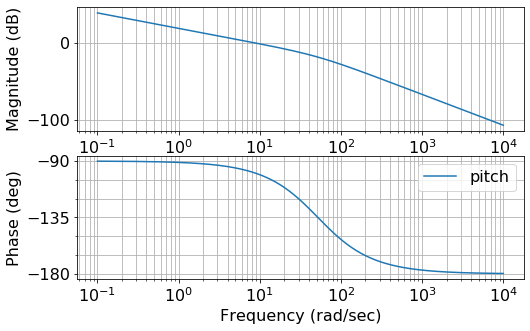

In [7]:
#ピッチレートのみ
plt.figure(figsize=(8,5))
plt.rcParams["font.size"] = 16
wfreq=np.logspace(-1,4,1000)
magq,phadeq,omegaq = matlab.bode(sysq,wfreq,label='pitch')
plt.legend()
plt.show()

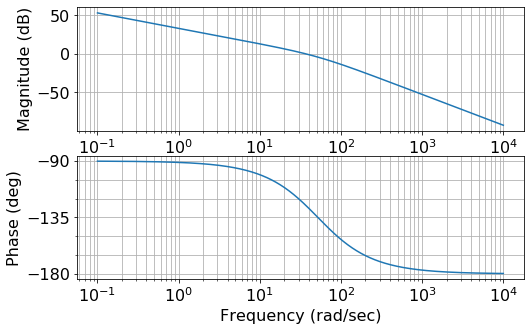

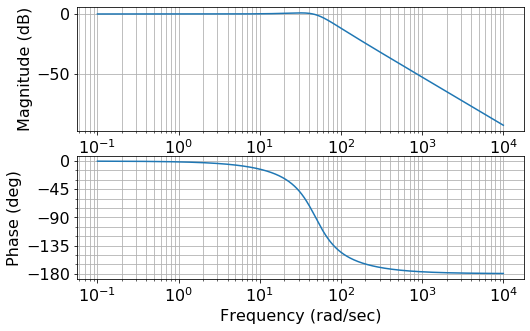

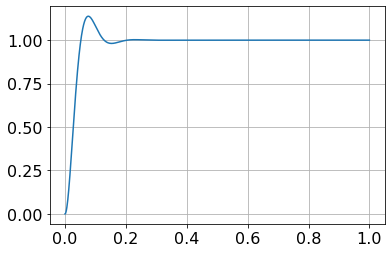

In [6]:
#Ti=0.01
Td=0.02
Kp=5
#cont=matlab.tf([Td*Kp, Kp],[1])
cont=Kp
L=sysq*cont
closesys=matlab.feedback(L)

#開ループボード線図
plt.figure(figsize=(8,5))
plt.rcParams["font.size"] = 16
wfreq=np.logspace(-1,4,1000)
magq,phadeq,omegaq = matlab.bode(L,wfreq,label='openloop')

#閉ループボード線図
plt.figure(figsize=(8,5))
plt.rcParams["font.size"] = 16
wfreq=np.logspace(-1,4,1000)
magq,phadeq,omegaq = matlab.bode(closesys,wfreq,label='closeloop')
plt.show()

#ステップ応答
t=np.linspace(0,1,1000)
y,t=matlab.step(closesys, t)
plt.plot(t,y)
plt.grid()
plt.show()


In [ ]:
Kp=1
Ti=0.045#0.045
#anglecont=matlab.tf([Kp, Kp/Ti],[1, 0])
anglecont=Kp
openloop=closesys*anglecont
systheta=matlab.feedback(openloop)

plt.figure(figsize=(8,5))
plt.rcParams["font.size"] = 16
wfreq=np.logspace(-1,4,1000)
magq,phadeq,omegaq = matlab.bode(openloop,wfreq,label='openloop')
plt.show()

plt.figure(figsize=(8,5))
plt.rcParams["font.size"] = 16
wfreq=np.logspace(-1,4,1000)
magq,phadeq,omegaq = matlab.bode(systheta,wfreq,label='openloop')
plt.show()

t=np.linspace(0,1,1000)
y,t=matlab.step(systheta, t)
plt.plot(t,y)
plt.grid()
plt.show()

